# Daniel Lupercio STAT 725 - HW1
## February 20, 2022

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
except Exception:
    pass

# TensorFlow ≥2.0 is required
import tensorflow as tf
assert tf.__version__ >= "2.0"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)


### Chapter 10, Exercise 10. 
Train a deep MLP on the MNIST dataset (you can load it using
keras.datasets.mnist.load_data(). See if you can get over
98% precision. Try searching for the optimal learning rate by using
the approach presented in this chapter (i.e., by growing the learning
rate exponentially, plotting the error, and finding the point where
the error shoots up). Try adding all the bells and whistles—save
checkpoints, use early stopping, and plot learning curves using
TensorBoard


In [2]:
from tensorflow import keras
from sklearn.model_selection import train_test_split

In [3]:
#mnist = keras.datasets.
# tf.keras.datasets.mnist.load_data(path = 'mnist.npz')
# I will not use the line below for now
# X,y = keras.datasets.mnist.load_data()
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.mnist.load_data(path = 'mnist.npz')
# X_train_full, X_test, y_train_full, y_test = train_test_split(X,y, train_size=0.7,random_state=4958)
print(X_train_full.dtype)
print(X_train_full.shape)
# X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.

uint8
(60000, 28, 28)


In [4]:
X_valid, X_train = train_test_split(X_train_full, train_size=0.7, random_state=4958) 
X_valid = X_valid/255.
X_train = X_train/255.
X_test = X_test/255.
# y_valid, y_train = y_train_full[:5000], y_train_full[5]

The validation set contains 42,000 images. The test set contains 10,000 images. The train set contains 18,000 images. These three datasets equate to 60,000. Which is the total number of images in the X_train_full set.

In [5]:
print(X_valid.dtype)
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

float64
(18000, 28, 28)
(42000, 28, 28)
(10000, 28, 28)


I will apply the same code to a y_validation, and y_train sets. These sets do not need to be divided by 255, to get a 0-1 range.

In [6]:
y_valid, y_train = train_test_split(y_train_full, train_size=0.7, random_state=4958) 
y_valid = y_valid
y_train = y_train
y_test = y_test

Something is not right, the y_train is returning floats instead of unit8. -Update, this has been fixed.

In [7]:
print(y_valid.dtype)
print(y_valid.shape) #validation set contians 42,000 images

#The labels are the class IDs (represented as uint8), from 0 to 9. The class IDs correspond to the digits represented in the images
print(y_train)

uint8
(42000,)
[9 3 4 ... 5 3 4]


Testing to see if the X_train set is working

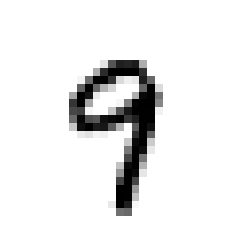

In [8]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

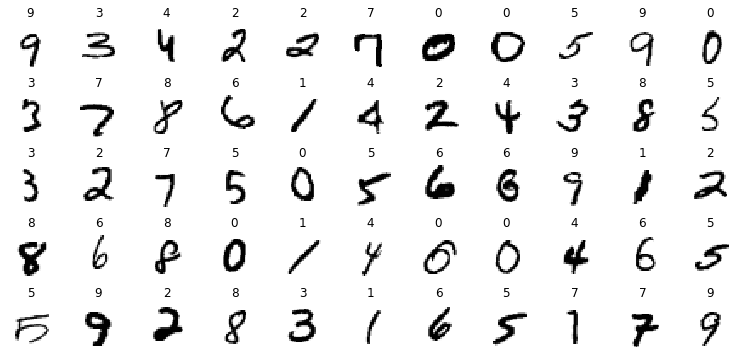

In [9]:
n_rows = 5
n_cols = 11
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off') #this removes the x and y axes values from each plot
        plt.title(y_train[index], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

Lets begin by creating a keras backend. Lets attempt to do this problem without the ExponentialLearningRate class

In [43]:
K = keras.backend
class ExponentialLearningRate(keras.callbacks.Callback):
    def __init__(self, factor):
        self.factor = factor
        self.rates = []
        self.losses = []
    def on_batch_end(self, batch, logs):
        self.rates.append(K.get_value(self.model.optimizer.learning_rate))
        self.losses.append(logs["loss"])
        K.set_value(self.model.optimizer.learning_rate, self.model.optimizer.learning_rate * self.factor)
        
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

We begin to add the layers to the model. The first input layer, with 300 neurons, has an input matrix X of m x 300. The weight vector of the hidden layer $W_h$ is 300 * 100. I have kept the activation function of the last layer the same.

In [44]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="relu") #If you want to guarantee that the output will always be positive, then you can use the ReLU activation function in the output layer.
])

In [45]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3), #Keras will perform the backprop. algo, & learning rate is .001
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(factor=1.005)

Lets begin by training the model with three epochs

In [46]:
history = model.fit(X_train, y_train, epochs = 3,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

563/563 [==============================] - 2s 2ms/step - loss: 3.1335 - accuracy: 0.1103 - val_loss: 2.3042 - val_accuracy: 0.1010


We see that the loss values decrease with the epochs, but the accuracy does not. A plot of the loss as a function can help us pinpoint an optimal learning rate

Text(0, 0.5, 'Loss')

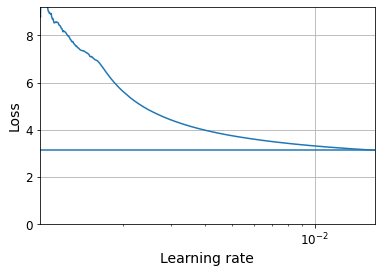

In [47]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

It appears that the Loss values will remain the same at about 2.2/2.3 as the learning rates increase.

Let's attempt to use the 'softmax' activation funciton on the output layer. Using the same intial learning rate, .001. Perhaps that gives us a distinct plot.

In [48]:
K = keras.backend
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax") 
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=1e-3), #Keras will perform the backprop. algo, & learning rate is .001
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=3,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

563/563 [==============================] - 1s 2ms/step - loss: 1.8136 - accuracy: 0.4576 - val_loss: 0.7742 - val_accuracy: 0.8282


Text(0, 0.5, 'Loss')

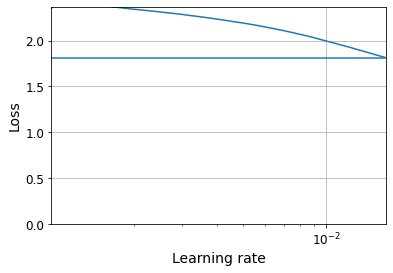

In [49]:
plt.plot(expon_lr.rates, expon_lr.losses)
plt.gca().set_xscale('log')
plt.hlines(min(expon_lr.losses), min(expon_lr.rates), max(expon_lr.rates))
plt.axis([min(expon_lr.rates), max(expon_lr.rates), 0, expon_lr.losses[0]])
plt.grid()
plt.xlabel("Learning rate")
plt.ylabel("Loss")

I can comprehend this plot better, as the loss function is decreasing up until approximately 0.5. Then by 0.3, it begins to shoot straight up. However, the accuracy is poor at approximately 45%

Lets reuse this model, but this time, with an initial learning rate of 0.5

In [50]:
K = keras.backend
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax") 
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer=keras.optimizers.SGD(learning_rate=5e-1), #Keras will perform the backprop. algo, & learning rate is .001
              metrics=["accuracy"])

expon_lr = ExponentialLearningRate(factor=1.005)

history = model.fit(X_train, y_train, epochs=3,
                    validation_data=(X_valid, y_valid),
                    callbacks=[expon_lr])

563/563 [==============================] - 2s 3ms/step - loss: nan - accuracy: 0.2420 - val_loss: nan - val_accuracy: 0.1000


In [51]:
run_index = 1 # increment this at every run
run_logdir = os.path.join(os.curdir, "my_mnist_logs", "run_{:03d}".format(run_index))
run_logdir

'.\\my_mnist_logs\\run_001'

In [57]:
?keras.callbacks.ModelCheckpoint

Init signature:
keras.callbacks.ModelCheckpoint(
    filepath,
    monitor='val_loss',
    verbose=0,
    save_best_only=False,
    save_weights_only=False,
    mode='auto',
    save_freq='epoch',
    options=None,
    **kwargs,
)
Docstring:     
Callback to save the Keras model or model weights at some frequency.

`ModelCheckpoint` callback is used in conjunction with training using
`model.fit()` to save a model or weights (in a checkpoint file) at some
interval, so the model or weights can be loaded later to continue the training
from the state saved.

A few options this callback provides include:

- Whether to only keep the model that has achieved the "best performance" so
  far, or whether to save the model at the end of every epoch regardless of
  performance.
- Definition of 'best'; which quantity to monitor and whether it should be
  maximized or minimized.
- The frequency it should save at. Currently, the callback supports saving at
  the end of every epoch, or after a fixed nu

In [52]:
early_stopping_cb = keras.callbacks.EarlyStopping(patience=20)
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_mnist_model.h5", save_best_only=True)
tensorboard_cb = keras.callbacks.TensorBoard(run_logdir)

history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb, tensorboard_cb])

Epoch 1/100
563/563 [==============================] - 3s 5ms/step - loss: nan - accuracy: 0.0957 - val_loss: nan - val_accuracy: 0.1000
Epoch 2/100
563/563 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0957 - val_loss: nan - val_accuracy: 0.1000
Epoch 3/100
563/563 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0957 - val_loss: nan - val_accuracy: 0.1000
Epoch 4/100
563/563 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0957 - val_loss: nan - val_accuracy: 0.1000
Epoch 5/100
563/563 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0957 - val_loss: nan - val_accuracy: 0.1000
Epoch 6/100
563/563 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0957 - val_loss: nan - val_accuracy: 0.1000
Epoch 7/100
563/563 [==============================] - 1s 2ms/step - loss: nan - accuracy: 0.0957 - val_loss: nan - val_accuracy: 0.1000
Epoch 8/100
563/563 [====================

In [54]:
#model = keras.models.load_model("my_mnist_model.h5") # rollback to best model
model.evaluate(X_test, y_test)

313/313 [==============================] - 0s 539us/step - loss: nan - accuracy: 0.0980


[nan, 0.09799999743700027]

### Chapter 11 Exercise 8
Practice training a deep neural network on the CIFAR10 image
dataset:

This is a dataset of 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. 

a. Build a DNN with 20 hidden layers of 100 neurons each
(that’s too many, but it’s the point of this exercise). Use
He initialization and the ELU activation function.

In [67]:
keras.backend.clear_session()
tf.random.set_seed(42)
np.random.seed(42)

model2 = keras.models.Sequential()
model2.add(keras.layers.Flatten(input_shape=[32, 32, 3]))
for d in range(20):
    model2.add(keras.layers.Dense(100,
                                 activation="elu",
                                 kernel_initializer="he_normal"))

In [ ]:
# model = keras.models.Sequential([
#     keras.layers.Flatten(input_shape=[28, 28]),
#     keras.layers.Dense(300, activation="relu"),
#     keras.layers.Dense(100, activation="relu"),
#     keras.layers.Dense(10, activation="softmax") 
# ])

b. Using Nadam optimization and early stopping, train the
network on the CIFAR10 dataset. You can load it with
keras.datasets.cifar10.load_ data(). The dataset is
composed of 60,000 32 × 32–pixel color images (50,000
for training, 10,000 for testing) with 10 classes, so you’ll
need a softmax output layer with 10 neurons. Remember
to search for the right learning rate each time you change
the model’s architecture or hyperparameters.

In [68]:
model2.add(keras.layers.Dense(10, activation='softmax'))

In [ ]:
optimizer = keras.optimizers.Nadam(learning_rate=5e-5) # momentum optimization
model.compile(loss="sparse_categorical_crossentropy",
              optimizer=optimizer,
              metrics=["accuracy"])

Model.save(...h5)?
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [59]:
(X_train_full2, y_train_full2), (X_test2, y_test2) = tf.keras.datasets.cifar10.load_data()
print(X_train_full2.shape)
print(y_train_full2.shape)
print(X_test2.shape)
print(y_test2.shape)
print(X_train_full2.dtype)

(50000, 32, 32, 3)
(50000, 1)
(10000, 32, 32, 3)
(10000, 1)
uint8


In [65]:
X_valid2, X_train2 = train_test_split(X_train_full2, train_size=0.7, random_state=4958)

print(X_valid2[0])
print(X_valid2.dtype)

[[[ 51  42  43]
  [ 50  38  38]
  [ 50  36  34]
  ...
  [ 89  91 104]
  [ 78  80  93]
  [ 94  96 108]]

 [[ 65  51  47]
  [ 63  47  41]
  [ 69  51  43]
  ...
  [ 98 100 113]
  [ 85  87 100]
  [ 96  98 111]]

 [[ 67  51  43]
  [ 59  41  32]
  [ 71  51  39]
  ...
  [ 98 100 113]
  [ 86  88 101]
  [ 98 100 112]]

 ...

 [[ 79  99 153]
  [ 77  97 159]
  [ 80 103 165]
  ...
  [ 74  89 124]
  [ 93  96 115]
  [101  98 113]]

 [[ 81  96 159]
  [ 78  94 166]
  [ 79  98 170]
  ...
  [ 64  82 119]
  [ 84  88 108]
  [101  95 108]]

 [[ 81  91 142]
  [ 75  86 147]
  [ 76  90 152]
  ...
  [ 57  73 108]
  [ 67  72  92]
  [ 92  86  99]]]
uint8
